# Lending Game

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.cluster import KMeans


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
#from pandas.errors import FutureWarning

warnings.simplefilter(action='ignore', category=FutureWarning)

## Past data

In [256]:
df_past = pd.read_csv('PastLoans.csv')
df_past.head()

,sex,employment,married,income,digital1,digital2,digital3,default
0,1,employed,1,33610,0.705613,0.068107,0.167038,0
1,1,employed,1,20650,0.000000,0.091152,0.000000,1
2,1,employed,1,8504,0.637625,0.000000,0.066207,0
3,1,employed,1,18460,0.276120,0.548380,0.625448,0
4,0,employed,0,8811,0.001974,0.500731,0.000000,1


In [269]:
df_past.income.value_counts().sort_index().tail(100)

income
556442      1
556813      1
560361      1
561234      1
561305      1
           ..
934574      1
966448      1
971726      1
977443      1
1000000    85
Name: count, Length: 100, dtype: int64

<AxesSubplot:>

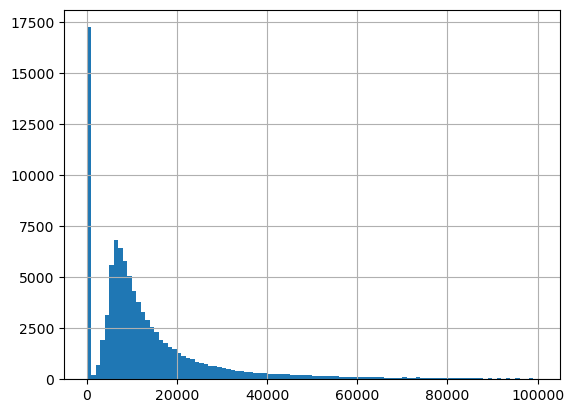

In [294]:
df_past.income[df_past.income < 100000].hist(bins=100)

In [286]:
df_past[df_past.income == 0].describe()

,sex,married,income,digital1,digital2,digital3,default
count,17082.000000,17082.000000,17082.0,17082.000000,17082.000000,17082.000000,17082.000000
mean,0.521133,0.340241,0.0,0.536250,0.536177,0.538790,0.408266
std,0.499568,0.473804,0.0,0.344739,0.343724,0.342981,0.491527
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.196529,0.199801,0.206733,0.000000
50%,1.000000,0.000000,0.0,0.613097,0.613142,0.618423,0.000000
75%,1.000000,1.000000,0.0,0.850282,0.849130,0.850812,1.000000
max,1.000000,1.000000,0.0,0.999989,0.999943,0.999998,1.000000


<AxesSubplot:>

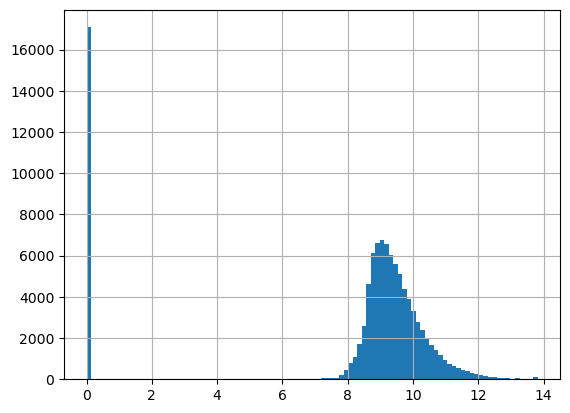

In [281]:
df_past.income.apply(lambda x : np.log(1+x)).hist(bins=100)

<AxesSubplot:>

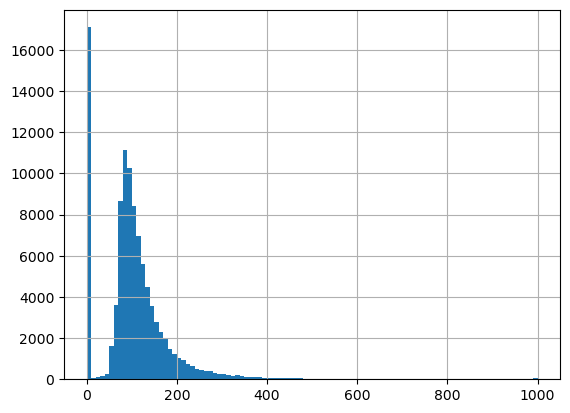

In [287]:
df_past.income.apply(lambda x : np.sqrt(x)).hist(bins=100)

In [67]:
df_past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   sex         100000 non-null  int64  
 1   employment  100000 non-null  object 
 2   married     100000 non-null  int64  
 3   income      100000 non-null  int64  
 4   digital1    100000 non-null  float64
 5   digital2    100000 non-null  float64
 6   digital3    100000 non-null  float64
 7   default     100000 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 6.1+ MB


### Data Encoding

In [68]:
#df_past.employment = df_past.employment.astype('category')
#df_past.sex = df_past.sex.astype('category')
#df_past.married = df_past.married.astype('category')
#df_past.default = df_past.default.astype('category')
df_past.income = df_past.income.astype('int32')
df_past.digital1 = df_past.digital1.astype('float32')
df_past.digital2 = df_past.digital2.astype('float32')
df_past.digital3 = df_past.digital3.astype('float32')

In [69]:
df_past.head()

,sex,employment,married,income,digital1,digital2,digital3,default
0,1,employed,1,33610,0.705613,0.068107,0.167038,0
1,1,employed,1,20650,0.000000,0.091152,0.000000,1
2,1,employed,1,8504,0.637625,0.000000,0.066207,0
3,1,employed,1,18460,0.276120,0.548380,0.625448,0
4,0,employed,0,8811,0.001974,0.500731,0.000000,1


In [70]:
df_past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   sex         100000 non-null  int64  
 1   employment  100000 non-null  object 
 2   married     100000 non-null  int64  
 3   income      100000 non-null  int32  
 4   digital1    100000 non-null  float32
 5   digital2    100000 non-null  float32
 6   digital3    100000 non-null  float32
 7   default     100000 non-null  int64  
dtypes: float32(3), int32(1), int64(3), object(1)
memory usage: 4.6+ MB


### Data Analysis

array([[<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'married'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'digital1'}>,
        <AxesSubplot:title={'center':'digital2'}>,
        <AxesSubplot:title={'center':'digital3'}>],
       [<AxesSubplot:title={'center':'default'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

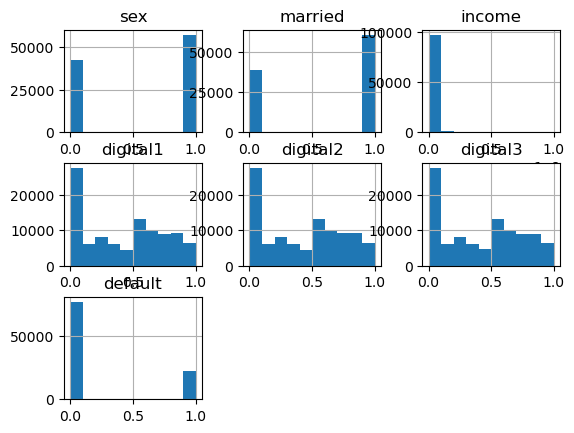

In [71]:
df_past.hist()

In [72]:
count_sex = df_past['sex'].value_counts()
count_married = df_past['married'].value_counts()
count_employment = df_past['employment'].value_counts()
count_default = df_past['default'].value_counts()

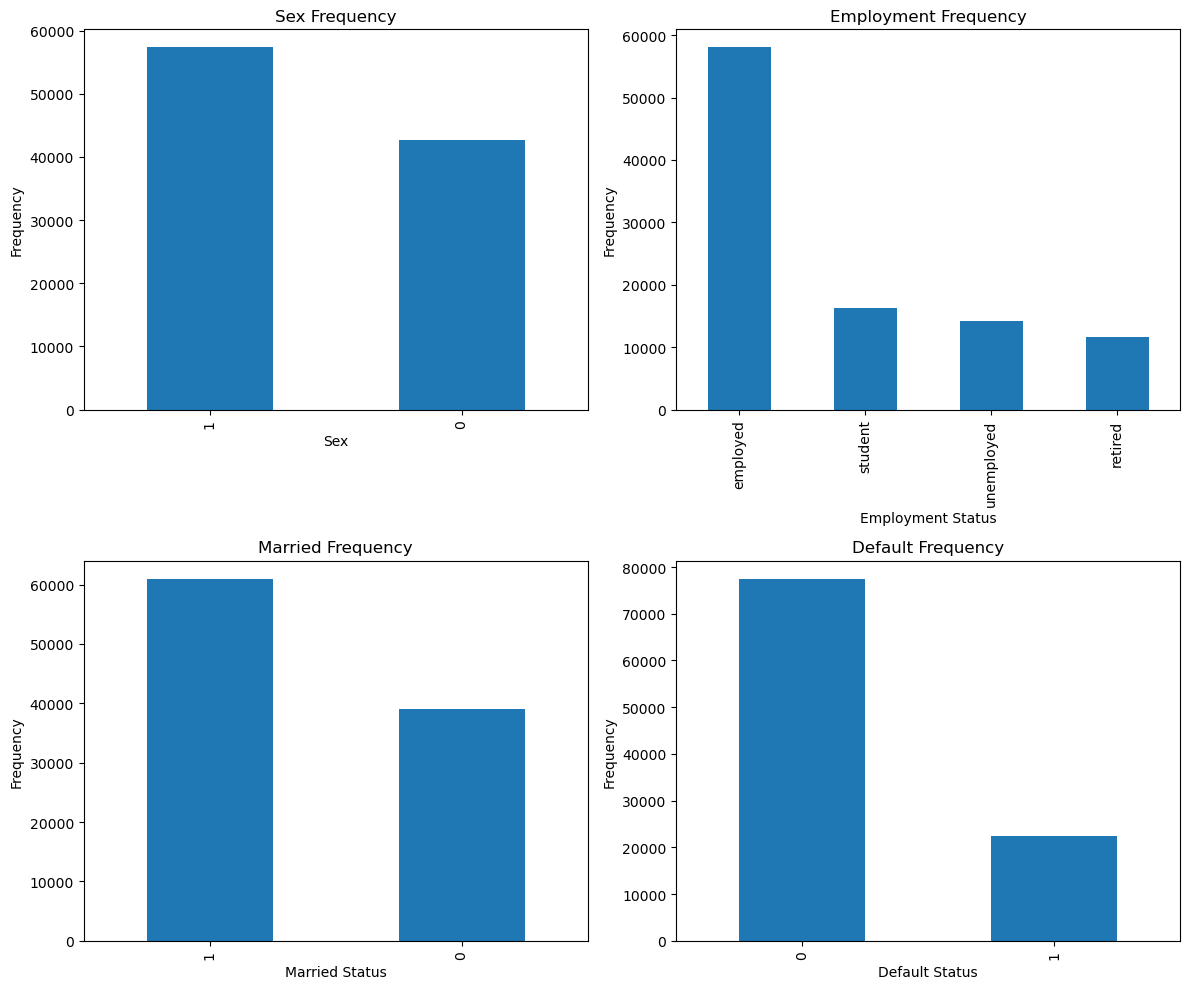

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))  # Added figsize for clarity

count_sex.plot(kind='bar', ax=ax[0,0])
ax[0,0].set_xlabel('Sex')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Sex Frequency')

count_married.plot(kind='bar', ax=ax[1,0])
ax[1,0].set_xlabel('Married Status')
ax[1,0].set_ylabel('Frequency')
ax[1,0].set_title('Married Frequency')

count_employment.plot(kind='bar', ax=ax[0,1])
ax[0,1].set_xlabel('Employment Status')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Employment Frequency')

count_default.plot(kind='bar', ax=ax[1,1])
ax[1,1].set_xlabel('Default Status')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_title('Default Frequency')

plt.tight_layout()
plt.show()


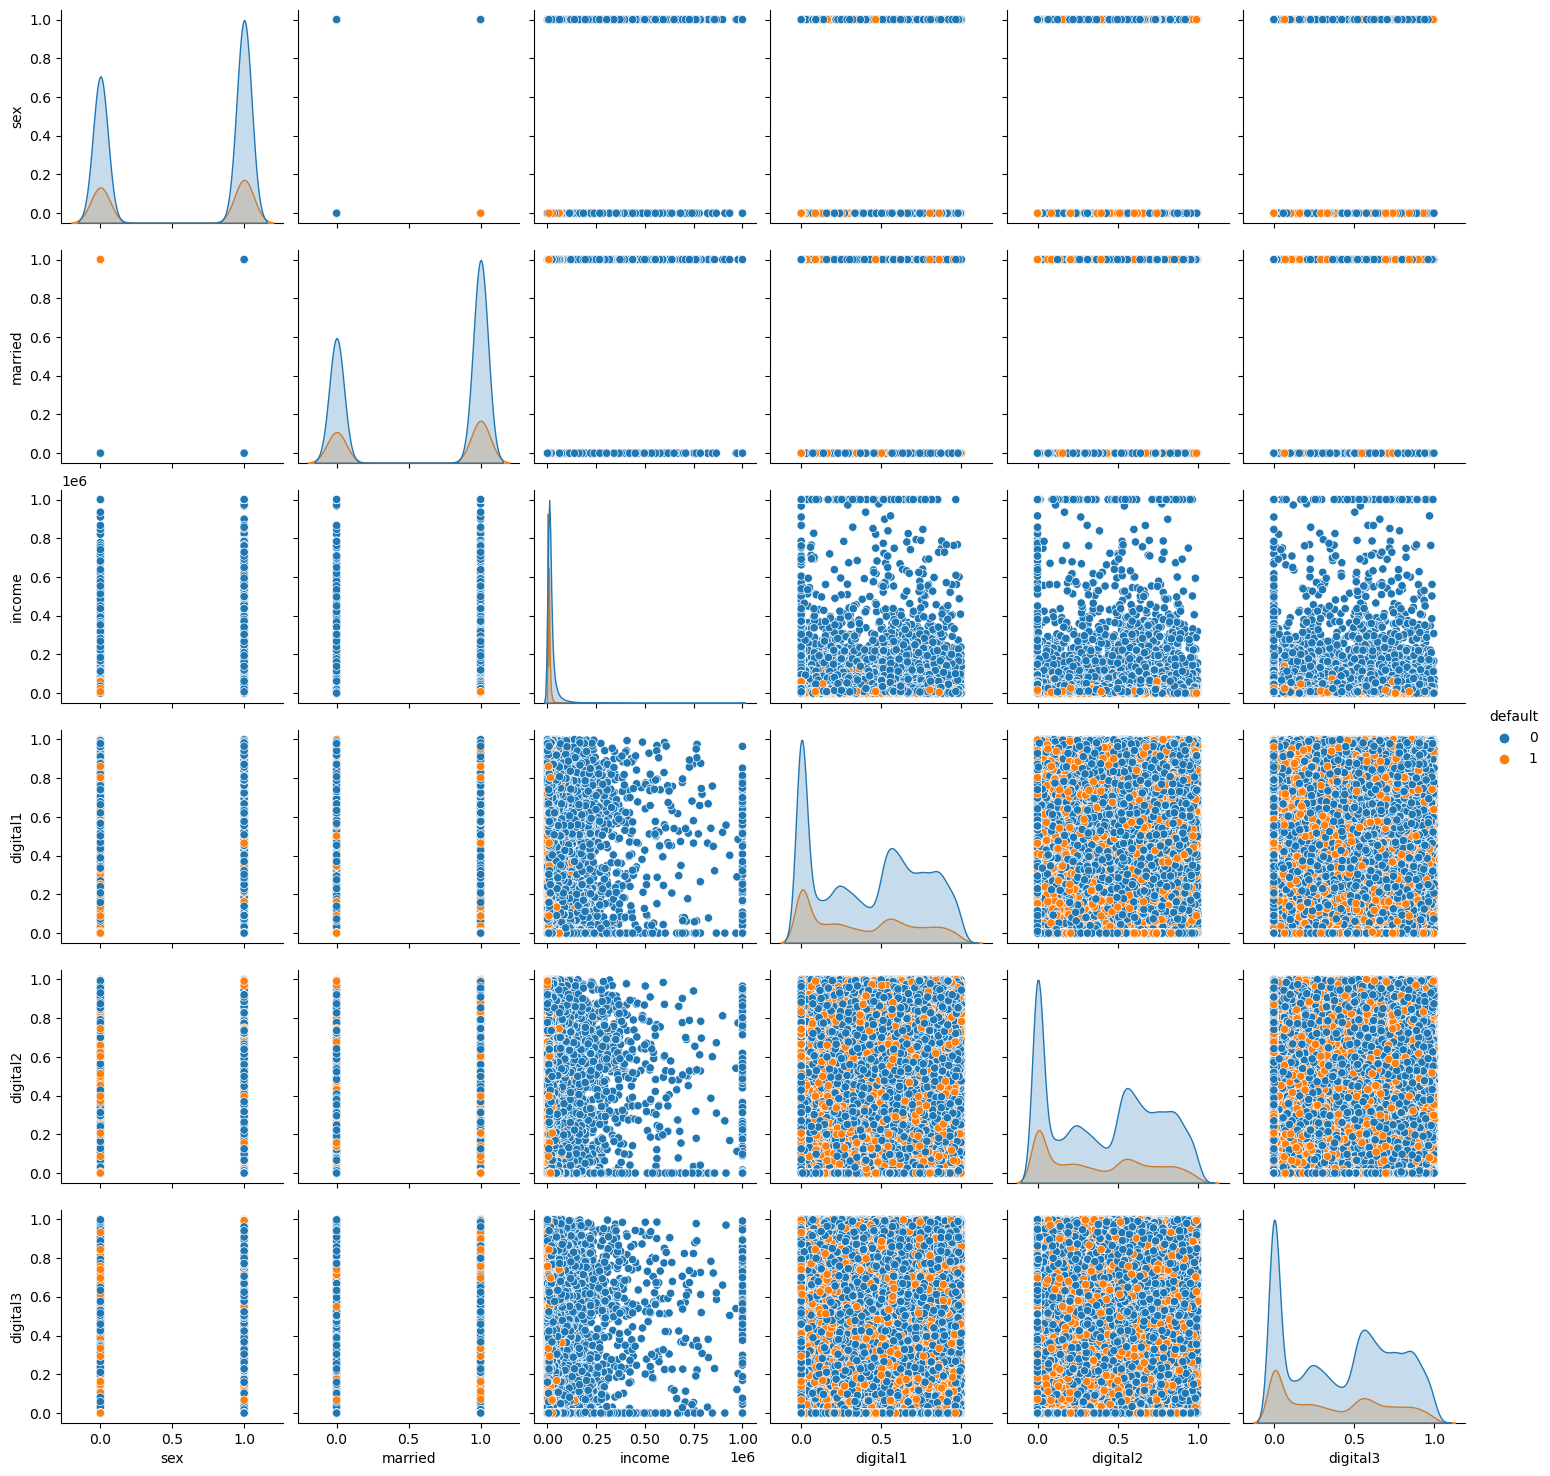

In [74]:
sns.pairplot(df_past, hue='default')

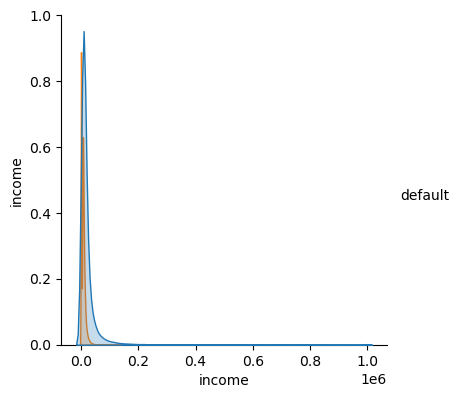

In [275]:
sns.pairplot(df_past[['income','default']], hue='default', height=4)
plt.show()

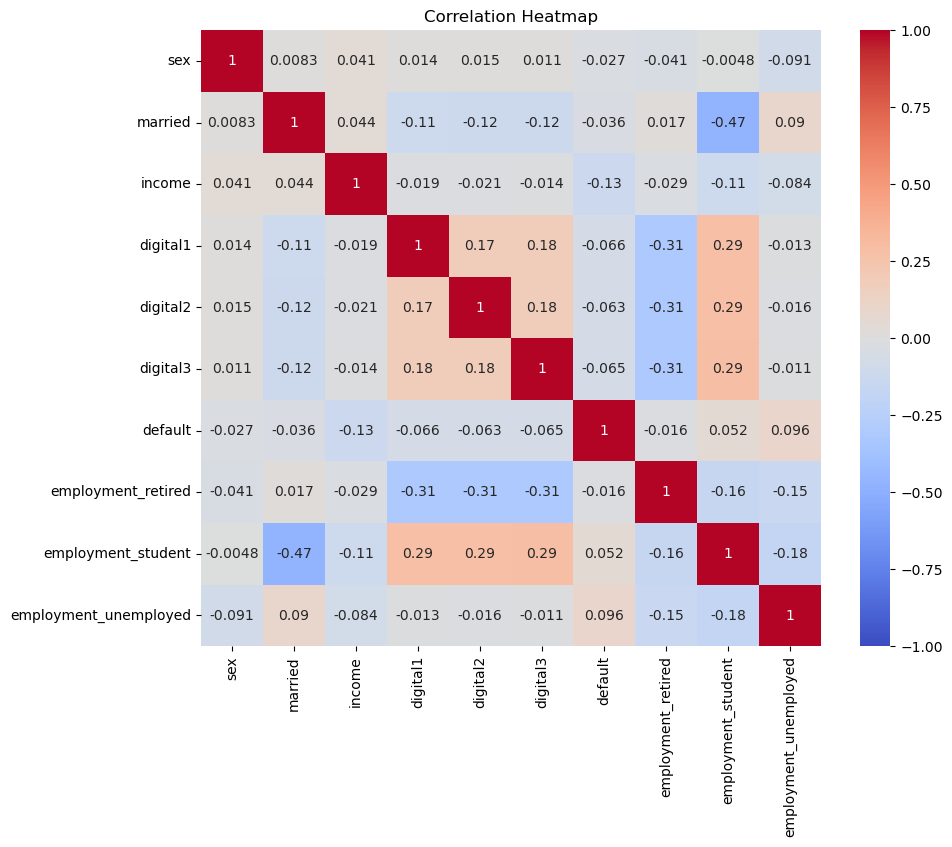

In [77]:
# Convert categorical columns to one-hot encoding
df_encoded = pd.get_dummies(df_past, drop_first=True)

# Compute the correlation matrix
corr = df_encoded.corr()

# Display the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


## Prediction part

### Preprocess

In [349]:
df_past = pd.read_csv('PastLoans.csv').drop(columns=['digital1','digital2'])
df_past.income = df_past.income.astype('int32')
#df_past.digital1 = df_past.digital1.astype('float32')
#df_past.digital2 = df_past.digital2.astype('float32')
df_past.digital3 = df_past.digital3.astype('float32')

In [3]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

def plot_func(y_test, y_pred, train=None, name=None):
    # Set up a (1,4) grid of plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Code 1: Scatter plot
    axes[0].scatter(y_test, y_pred)
    axes[0].set_xlabel('True Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title('Scatter Plot of True vs. Predicted Values')

    # Calculate thresholds and misclassification rates
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    
    # Determine the threshold with the minimum misclassification rate
    optimal_threshold = thresholds[np.argmin(misclassification_rates)]

    # Code 2: Confusion matrix heatmap
    y_pred_class = (y_pred > optimal_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('True labels')
    axes[1].set_title(f'Confusion Matrix Heatmap - Threshold = {optimal_threshold:.2f}')


    # Code 3: ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = roc_auc_score(y_test, y_pred)
    test_line, = axes[2].plot(fpr, tpr, color='blue', label=f'AUC_test = {auc_value:.3f}')
    axes[2].plot([0, 1], [0, 1], color='red', linestyle='--')
    axes[2].set_xlabel('False Positive Rate (FPR)')
    axes[2].set_ylabel('True Positive Rate (TPR)')
    axes[2].set_title('ROC Curve')

    # If train data provided, plot its ROC curve too
    if train is not None:
        fpr, tpr, thresholds = roc_curve(train[0], train[1])
        auc_value = roc_auc_score(train[0], train[1])
        train_line, = axes[2].plot(fpr, tpr, linestyle='--', color='blue', label=f'AUC_train = {auc_value:.3f}')

    # Legend adjustments for ROC Curve
    if train is not None:
        axes[2].legend(handles=[test_line, train_line], loc='best')
    else:
        axes[2].legend(loc='best')

    # Code 4: Misclassification Rate as function of Threshold
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    axes[3].plot(thresholds, misclassification_rates, label='Misclassification Rate')
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('Misclassification Rate')
    axes[3].set_title('Misclassification Rate vs. Threshold')
    axes[3].legend(loc='best')

    fig.suptitle(name, fontsize=15)

    # Display the concatenated plots
    plt.tight_layout()
    plt.show()

def misclassification_rate(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp + fn) / (tp + tn + fp + fn)


### Baseline - Linear regression

In [233]:
features_to_encode = ['employment']
df_encoded = pd.get_dummies(df_past, columns=features_to_encode)

# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['default']), df_encoded['default'], test_size=0.2, random_state=42)

# 4. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Perform linear regression
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

# Predict
y_pred = regressor.predict(X_test_scaled)

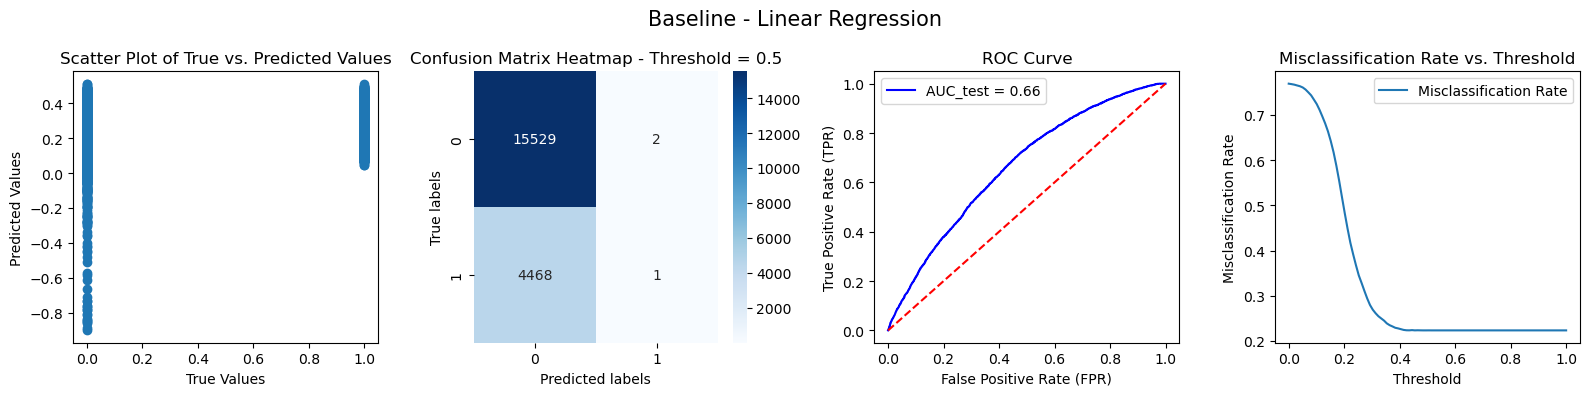

In [234]:
plot_func(y_test, y_pred, name="Baseline - Linear Regression")

### XGBoost Regressor

In [235]:
features_to_encode = ['employment']
df_encoded = pd.get_dummies(df_past, columns=features_to_encode)

# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['default']), df_encoded['default'], test_size=0.2, random_state=42)

# 4. Standardize the features (Note: XGBoost doesn't necessarily require feature scaling, but we'll keep it for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Perform regression using XGBoost
regressor = XGBRegressor(objective ='reg:squarederror') # Added this to suppress warning
regressor.fit(X_train_scaled, y_train)

# Predict
y_pred = regressor.predict(X_test_scaled)

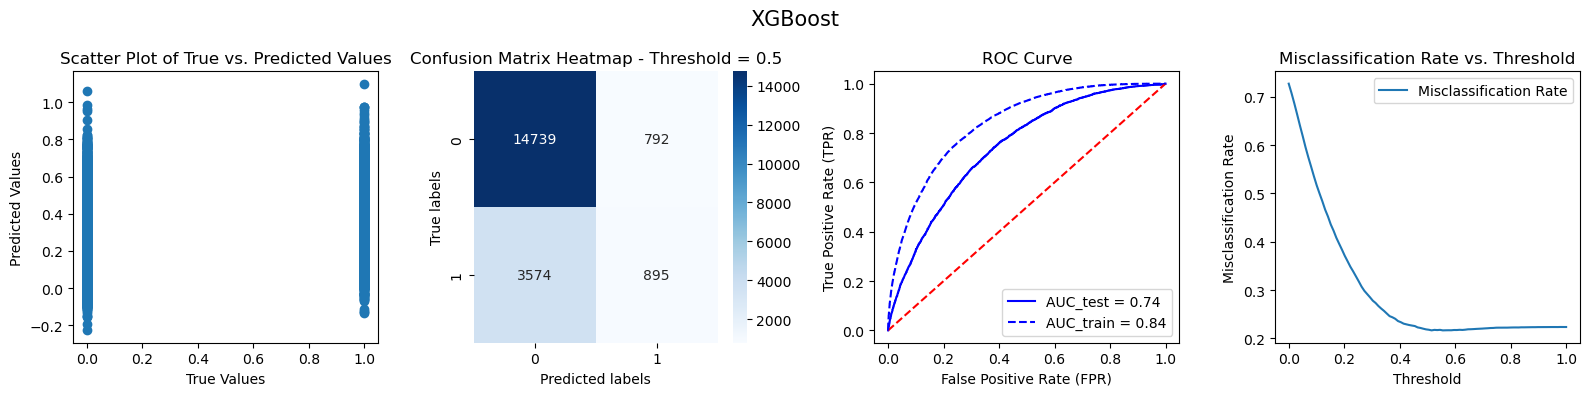

In [236]:
plot_func(y_test, y_pred,train=(y_train, regressor.predict(X_train_scaled)), name='XGBoost')

### Cat Boost

In [237]:
features_to_encode = ['employment']
df_encoded = pd.get_dummies(df_past, columns=features_to_encode)

# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['default']), df_encoded['default'], test_size=0.2, random_state=42)

# 4. Standardize the features (Note: CatBoost doesn't necessarily require feature scaling, but we'll keep it for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Perform regression using CatBoost
regressor = CatBoostRegressor(logging_level='Silent') # Logging level set to 'Silent' to suppress iteration-level outputs
regressor.fit(X_train_scaled, y_train)

# Predict
y_pred = regressor.predict(X_test_scaled)

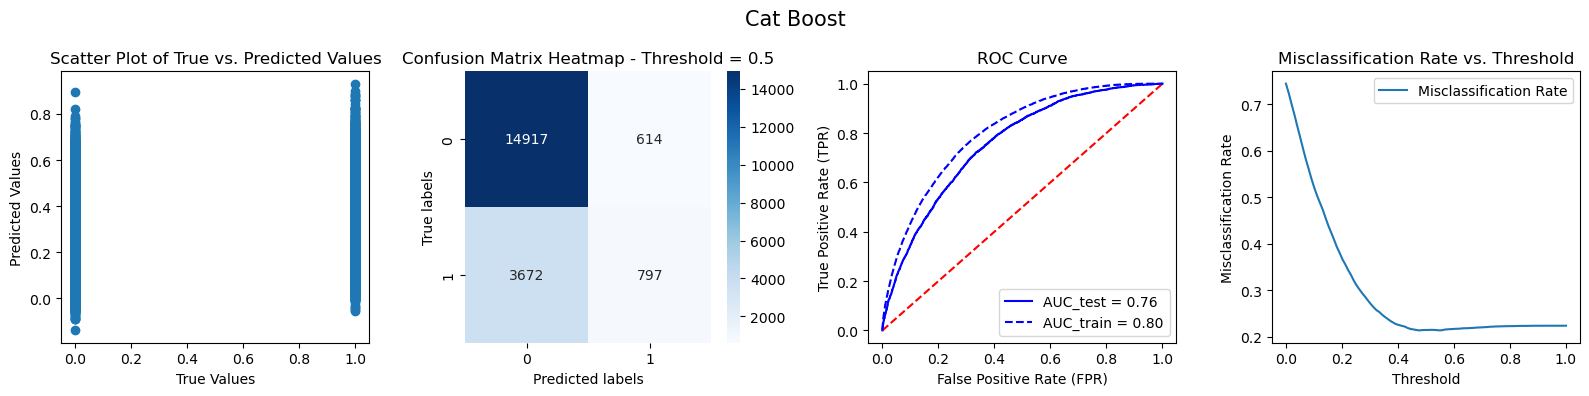

In [238]:
plot_func(y_test, y_pred,train=(y_train, regressor.predict(X_train_scaled)), name='Cat Boost')

### Cat Boost with Target Encoding

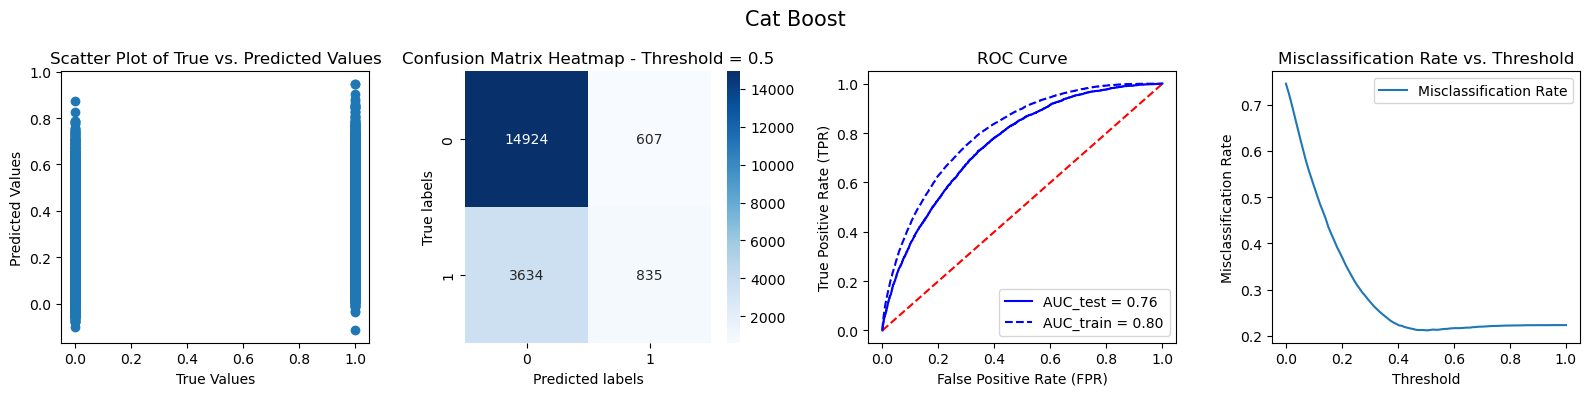

In [239]:
features_to_encode = ['employment']
df_encoded = pd.get_dummies(df_past, columns=features_to_encode)
cols_to_encode = ['sex', 'employment_employed', 'employment_retired','employment_student','employment_unemployed', 'married']

for col in cols_to_encode:
    df_encoded[col] = df_encoded[col].map(df_encoded.groupby(col).default.mean())

# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['default']), df_encoded['default'], test_size=0.2, random_state=42)

# 4. Standardize the features (Note: CatBoost doesn't necessarily require feature scaling, but we'll keep it for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Perform regression using CatBoost
regressor = CatBoostRegressor(logging_level='Silent') # Logging level set to 'Silent' to suppress iteration-level outputs
regressor.fit(X_train_scaled, y_train)

# Predict
y_pred = regressor.predict(X_test_scaled)

plot_func(y_test, y_pred,train=(y_train, regressor.predict(X_train_scaled)), name='Cat Boost')

### Cat Boost with Frequency Encoding

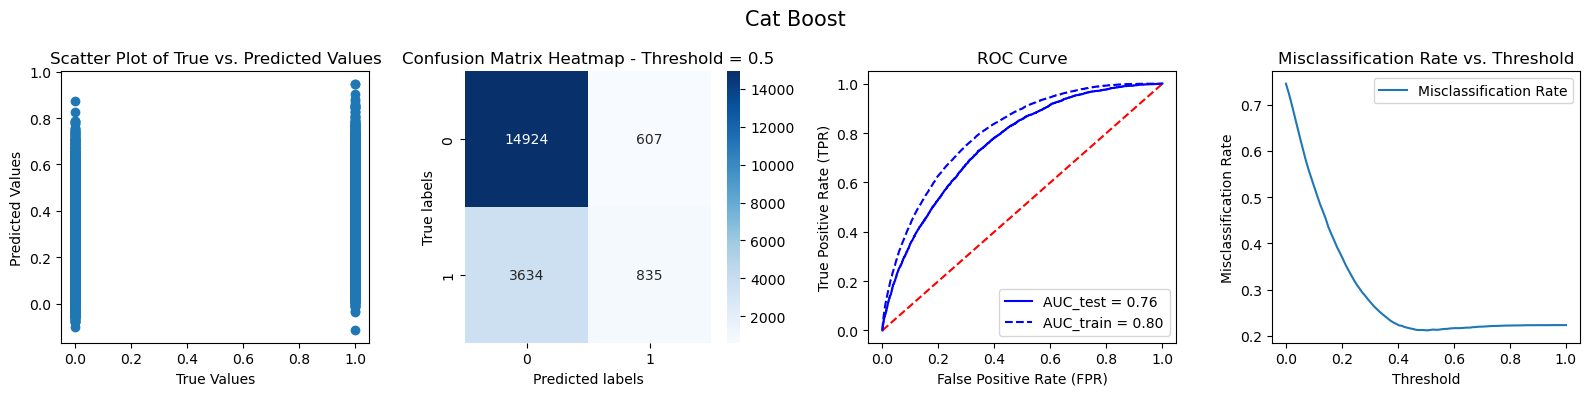

In [271]:
features_to_encode = ['employment']
df_encoded = pd.get_dummies(df_past, columns=features_to_encode)
cols_to_encode = ['sex', 'employment_employed', 'employment_retired','employment_student','employment_unemployed', 'married']

for col in cols_to_encode:
    df_encoded[col] = df_encoded[col].map(df_encoded.groupby(col)[col].count()) / df_encoded.shape[0]

# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['default']), df_encoded['default'], test_size=0.2, random_state=42)

# 4. Standardize the features (Note: CatBoost doesn't necessarily require feature scaling, but we'll keep it for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Perform regression using CatBoost
regressor = CatBoostRegressor(logging_level='Silent') # Logging level set to 'Silent' to suppress iteration-level outputs
regressor.fit(X_train_scaled, y_train)

# Predict
y_pred = regressor.predict(X_test_scaled)

plot_func(y_test, y_pred,train=(y_train, regressor.predict(X_train_scaled)), name='Cat Boost')

### Cat Boost - Frequency Encoded- Optimized

In [167]:
df_past = pd.read_csv('PastLoans.csv').drop(columns=['digital1','digital2'])
df_past.income = df_past.income.astype('int32')
df_past.digital3 = df_past.digital3.astype('float32')
df_past.employment = df_past.employment.astype('category')
df_past.sex = df_past.sex.astype('category')
df_past.married = df_past.married.astype('category')
df_past.default = df_past.default.astype('category')
df_past.income = df_past.income.rank()

100%|███████| 100/100 [06:32<00:00,  3.92s/trial, best loss: 0.2584027694544144]


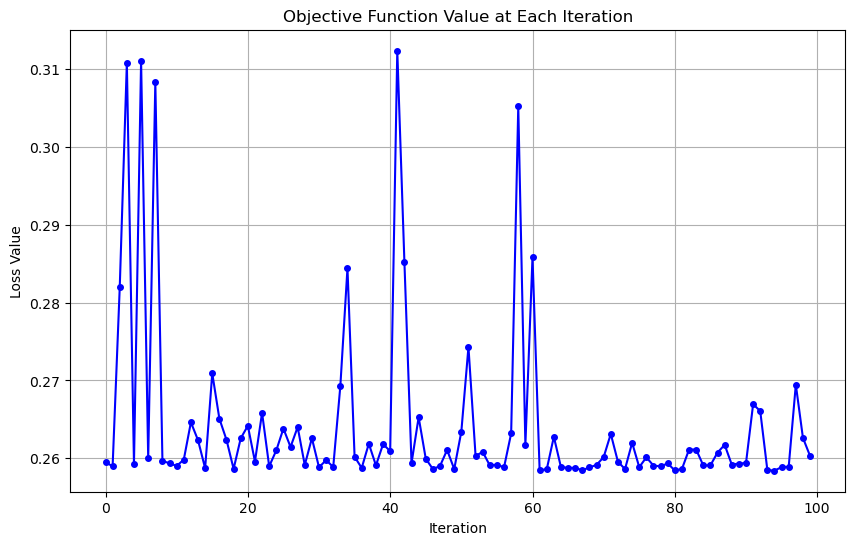

In [168]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2,
                                                    random_state=42)


# Objective function for hyperopt
def objective(params):
    model = CatBoostRegressor(
        iterations=500,
        learning_rate=params['learning_rate'],
        depth=int(params['depth']),
        l2_leaf_reg=params['l2_leaf_reg'],
#        border_count=params['border_count'],
        grow_policy=params['grow_policy'],
        min_data_in_leaf=params['min_data_in_leaf'],
        bootstrap_type=params['bootstrap_type'],
        cat_features=X_train.select_dtypes(['category']).columns.tolist(),  # Handle categorical features
        logging_level='Silent'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = 1 - roc_auc_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}


# Search space
# Expanded Search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 5),
#    'border_count': hp.quniform('border_count', 1, 255, 5),
    'grow_policy': hp.choice('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
    'bootstrap_type': hp.choice('bootstrap_type', ["Bayesian", "Bernoulli", "MVS", "No"]),


#    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1)
}



# Then use the same fmin function and objective function to find the best hyperparameters.


# Run the optimizer
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

#print(f"Best hyperparameters:\n{best}")

losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses, '-o', color='blue', markersize=4)
plt.title('Objective Function Value at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

In [169]:
best

{'bootstrap_type': 3,
 'depth': 7.0,
 'grow_policy': 0,
 'l2_leaf_reg': 3.146518971506603,
 'learning_rate': 0.02669416416480637,
 'min_data_in_leaf': 104.0}

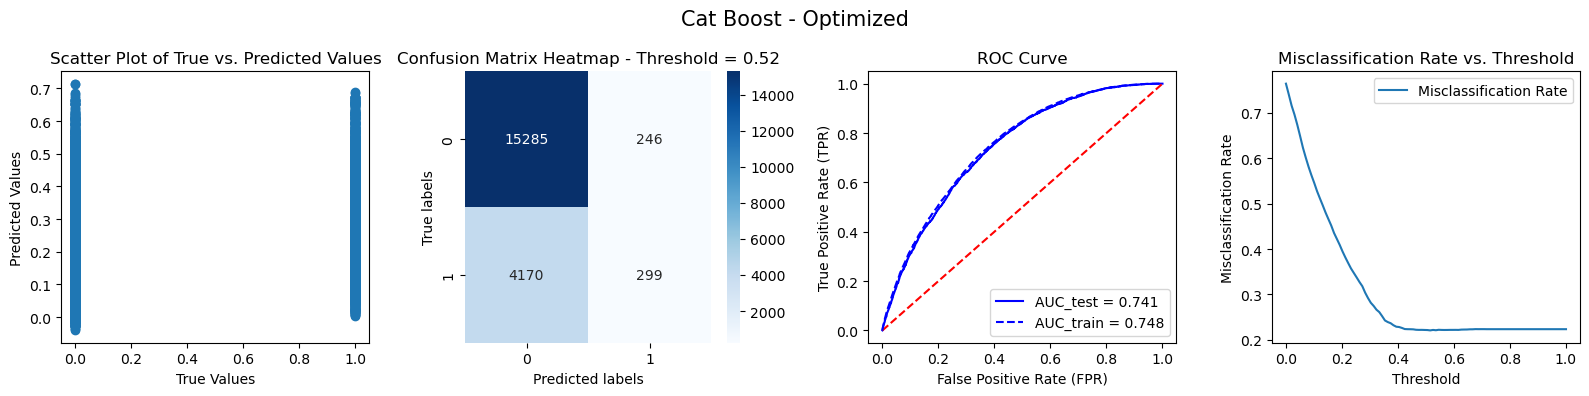

In [170]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2,
                                                    random_state=42)

# Ensure `best` is available and contains the necessary hyperparameters
assert 'bootstrap_type' in best and 'grow_policy' in best

# Map the hyperparameters
best_hyperparameters = best.copy()

best_hyperparameters['bootstrap_type'] = ["Bayesian", "Bernoulli", "MVS", "No"][best['bootstrap_type']]
best_hyperparameters['grow_policy'] = ["SymmetricTree", "Depthwise", "Lossguide"][best['grow_policy']]
best_hyperparameters['depth'] = int(best['depth'])
#best_hyperparameters['border_count'] = int(best['border_count'])

# Add categorical features
cat_features = X_train.select_dtypes(['category']).columns.tolist()
best_hyperparameters['cat_features'] = cat_features

# Initialize the regressor
regressor_cat = CatBoostRegressor(**best_hyperparameters, logging_level='Silent') 

# Fit the model
regressor_cat.fit(X_train, y_train)

# Predict
y_pred = regressor_cat.predict(X_test)

# Ensure the plot_func exists
if 'plot_func' in globals():
    plot_func(y_test, y_pred, train=(y_train, regressor_cat.predict(X_train)), name='Cat Boost - Optimized')
else:
    print("plot_func is not defined!")


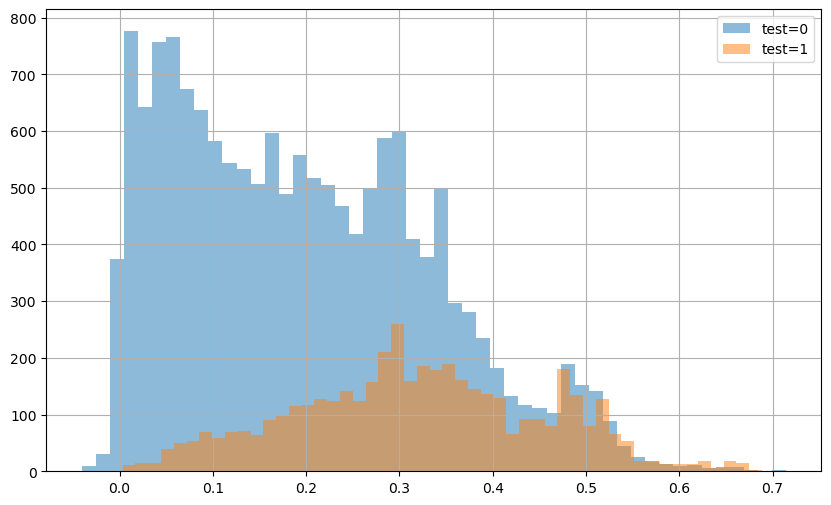

In [171]:
df_ = pd.DataFrame()
df_['pred'] = y_pred
df_['test'] = y_test.to_numpy()

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_.groupby(by='test'):
    group.pred.hist(ax=ax, bins=50, alpha=0.5, label=f"test={key}")

# Adding legend to differentiate between groups
ax.legend()

plt.show()

In [172]:
df_['bins'] = pd.cut(df_['pred'], 30)
df_['risk_free_rate'] = [df_[df_.bins == x].test.mean() / (1 - df_[df_.bins == x].test.mean()) for x in df_.bins.to_numpy()]

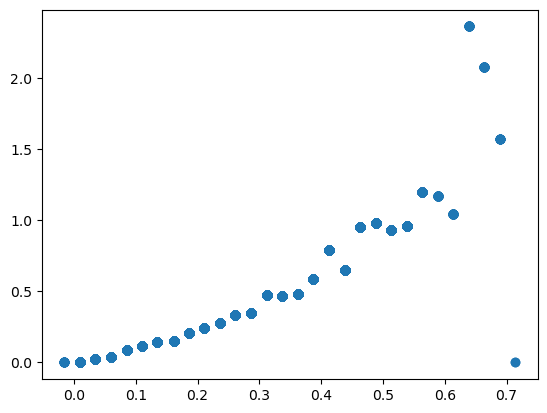

In [173]:
plt.scatter(x=[x.right for x in df_.bins.to_numpy()], y=df_.risk_free_rate)

### Cluster

In [230]:
df_past = pd.read_csv('PastLoans.csv')
df_past.income = df_past.income.astype('int32')
df_past.digital1 = df_past.digital1.astype('float32')
df_past.digital2 = df_past.digital2.astype('float32')
df_past.digital3 = df_past.digital3.astype('float32')

features_to_encode = ['employment']
df_encoded = pd.get_dummies(df_past, columns=features_to_encode)
cols_to_encode = ['sex', 'employment_employed', 'employment_retired','employment_student','employment_unemployed', 'married']

for col in cols_to_encode:
    df_encoded[col] = df_encoded[col].map(df_encoded.groupby(col)[col].count()) / df_encoded.shape[0]

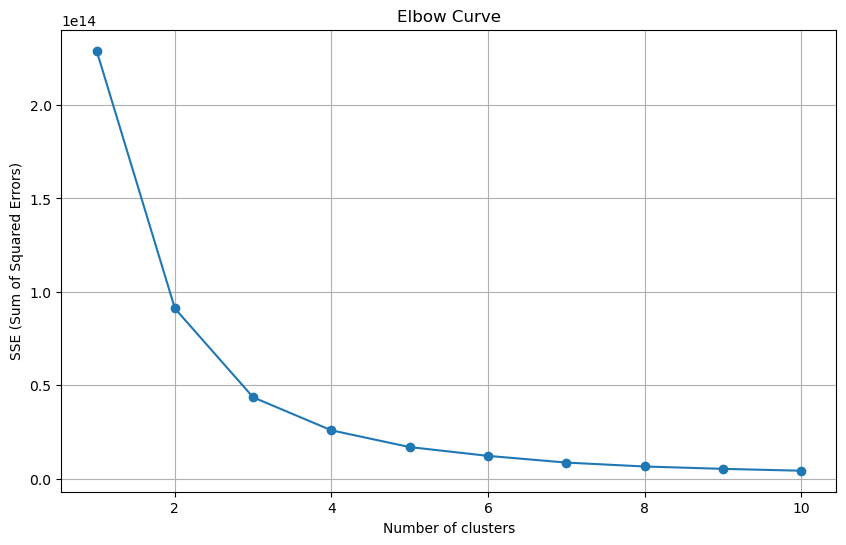

[229075248629623.6,
 91092849695628.7,
 43519728734011.31,
 25859404021902.062,
 16896001214792.98,
 12192362260413.996,
 8599195651757.627,
 6505896472716.21,
 5245476199254.15,
 4243551079642.375]

In [231]:
def elbow_method(df, max_clusters):
    """
    Apply KMeans clustering to the dataframe df for several number of clusters.
    
    Args:
    - df (pd.DataFrame): DataFrame to cluster.
    - max_clusters (int): Maximum number of clusters to consider.
    
    Returns:
    - None (but it plots the elbow curve).
    """
    # Store the sum of squared distances (inertia) for each k
    sse = []
    
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        sse.append(kmeans.inertia_)
    
    # Plot the elbow curve
    plt.figure(figsize=(10,6))
    plt.plot(range(1, max_clusters+1), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.title('Elbow Curve')
    plt.grid(True)
    plt.show()
    return(sse)


elbow_method(df_encoded.drop(columns=['default']), max_clusters=10)

nbr_cluster = 2
nbr_cluster = 3
nbr_cluster = 4
nbr_cluster = 5
nbr_cluster = 6
nbr_cluster = 7
nbr_cluster = 8
nbr_cluster = 9
nbr_cluster = 10


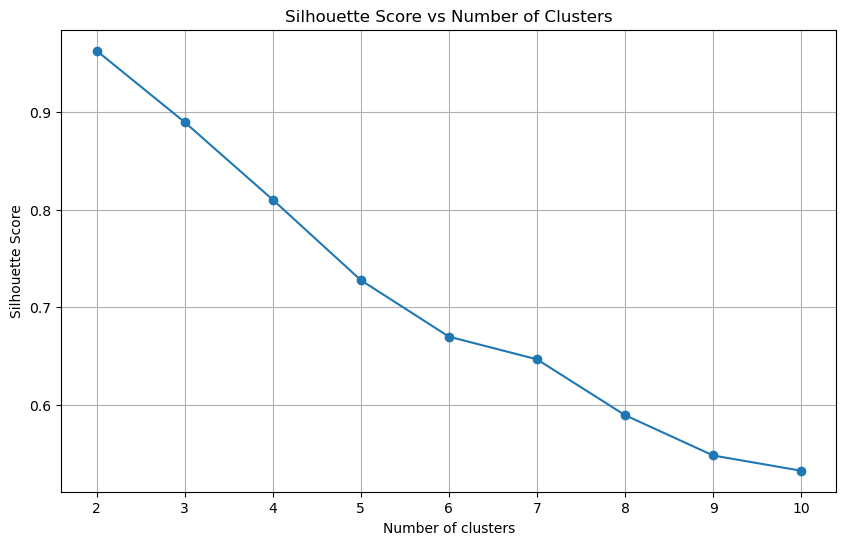

[0.9626045978408921,
 0.8894151563646899,
 0.8100444850916104,
 0.7276690726311414,
 0.669816495946308,
 0.6466034617356459,
 0.5894281488964076,
 0.5481386156703059,
 0.5325289307110417]

In [243]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def silhouette_method(df, max_clusters):
    """
    Apply KMeans clustering to the dataframe df for several number of clusters and compute silhouette scores.
    
    Args:
    - df (pd.DataFrame): DataFrame to cluster.
    - max_clusters (int): Maximum number of clusters to consider.
    
    Returns:
    - None (but it plots the silhouette scores for each number of clusters).
    """
    # Store the silhouette scores for each k
    silhouette_scores = []
    
    # We start from 2 clusters because silhouette score isn't defined for a single cluster
    for k in range(2, max_clusters+1):
        print(f'nbr_cluster = {k}')
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_assignments = kmeans.fit_predict(df)
        score = silhouette_score(df, cluster_assignments)
        silhouette_scores.append(score)
    
    # Plot the silhouette scores
    plt.figure(figsize=(10,6))
    plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    plt.show()
    
    return silhouette_scores

silhouette_method(df_encoded.drop(columns=['default']), max_clusters=10)

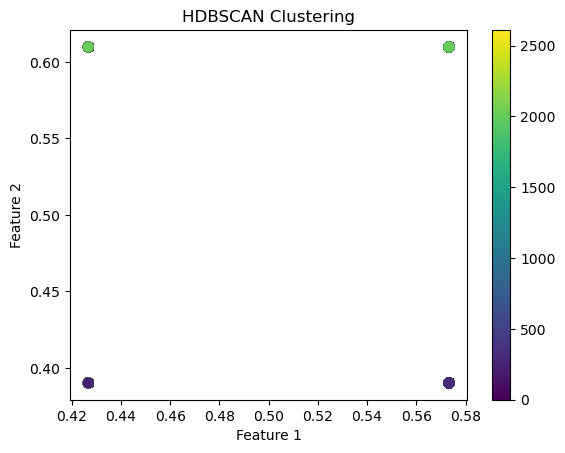

In [247]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np

def hdbscan_clustering(df, min_cluster_size=5, min_samples=None):
    """
    Apply HDBSCAN clustering to the dataframe df.
    
    Args:
    - df (pd.DataFrame): DataFrame to cluster.
    - min_cluster_size (int): The smallest size grouping to be considered a cluster.
    - min_samples (int): How conservative the clustering should be.
    
    Returns:
    - cluster_labels (array): Labels of clusters for each point in the dataset.
    """
    # Apply HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True)
    cluster_labels = clusterer.fit_predict(df)
    
    # Plot the clusters
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=cluster_labels, cmap='viridis', s=50)
    plt.title('HDBSCAN Clustering')
    plt.xlabel('Feature 1')  # Adjust based on your dataset
    plt.ylabel('Feature 2')  # Adjust based on your dataset
    plt.colorbar()
    plt.show()

    return cluster_labels

# Use the function on your dataset
cluster_labels = hdbscan_clustering(df_encoded.drop(columns=['default']))

# This will display a scatter plot with each point colored based on its cluster label.
# Noise points (those not belonging to any cluster) will typically have a label of -1.


### Optimized XGBoost

100%|███████| 100/100 [01:20<00:00,  1.24trial/s, best loss: 0.2591176434187976]
Best hyperparameters:
{'colsample_bytree': 0.8136356158407416, 'gamma': 0.00034827578429099683, 'learning_rate': 0.013671562060926234, 'max_depth': 4.0, 'min_child_weight': 0.4027965586750206, 'reg_alpha': 6.580836922169169, 'reg_lambda': 3.787333076145355, 'subsample': 0.9130516814907246}


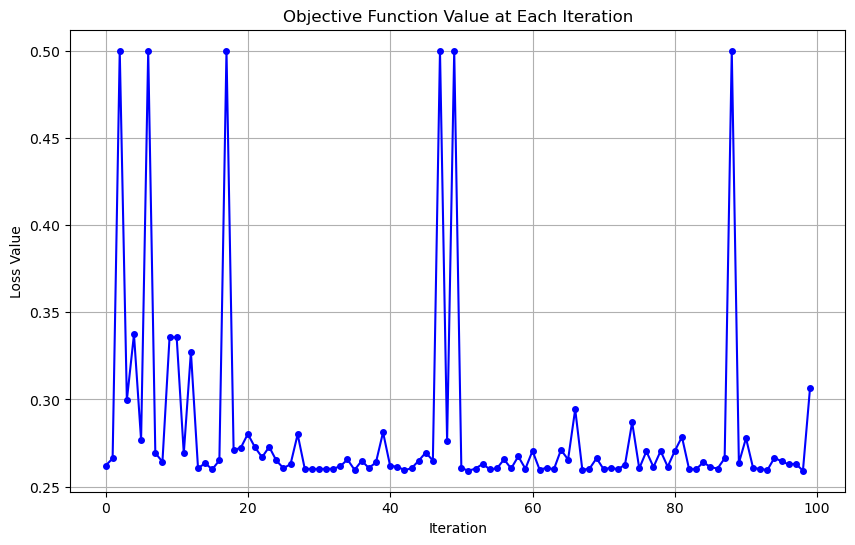

In [174]:
df_past = pd.read_csv('PastLoans.csv').drop(columns=['digital1','digital2'])
df_past.income = df_past.income.astype('int32')
df_past.digital3 = df_past.digital3.astype('float32')
df_past.employment = df_past.employment.astype('category')
df_past.sex = df_past.sex.astype('category')
df_past.married = df_past.married.astype('category')
df_past.default = df_past.default.astype('category')


# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2,
                                                    random_state=42)



# Objective function for hyperopt
def objective(params):
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        eval_metric='auc'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = 1 - roc_auc_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

# Search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 8, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'random_state':42
}

# Run the optimizer
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(f"Best hyperparameters:\n{best}")

losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses, '-o', color='blue', markersize=4)
plt.title('Objective Function Value at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

In [179]:
best

{'colsample_bytree': 0.8136356158407416,
 'gamma': 0.00034827578429099683,
 'learning_rate': 0.013671562060926234,
 'max_depth': 4,
 'min_child_weight': 0.4027965586750206,
 'reg_alpha': 6.580836922169169,
 'reg_lambda': 3.787333076145355,
 'subsample': 0.9130516814907246}

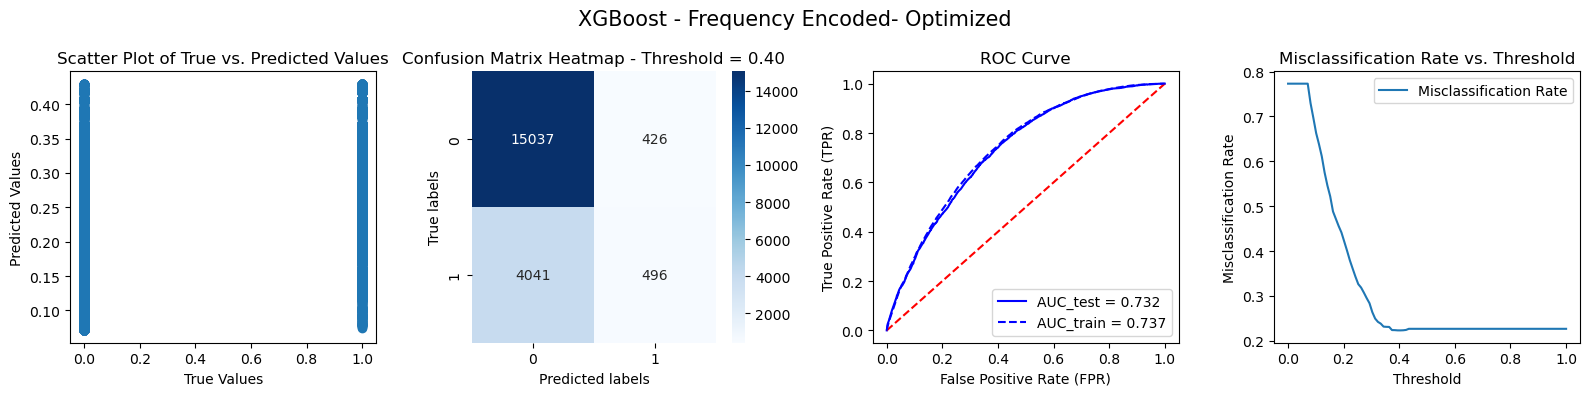

In [175]:
# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2)


# 5. Perform regression using CatBoost

best['max_depth'] = int(best['max_depth'])

best_hyperparameters = best

regressor_xgb = xgb.XGBRegressor(**best_hyperparameters,enable_categorical=True) # Logging level set to 'Silent' to suppress iteration-level outputs
regressor_xgb.fit(X_train, y_train)

# Predict
y_pred = regressor_xgb.predict(X_test)

plot_func(y_test, y_pred, train=(y_train, regressor_xgb.predict(X_train)), name='XGBoost - Frequency Encoded- Optimized')


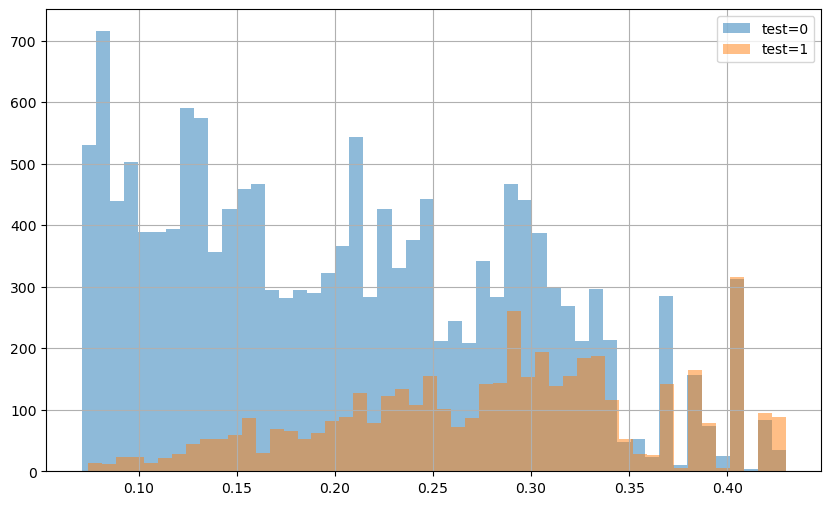

In [176]:
df_ = pd.DataFrame()
df_['pred'] = y_pred
df_['test'] = y_test.to_numpy()

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_.groupby(by='test'):
    group.pred.hist(ax=ax, bins=50, alpha=0.5, label=f"test={key}")

# Adding legend to differentiate between groups
ax.legend()

plt.show()

In [177]:
df_['bins'] = pd.cut(df_['pred'], 30)
df_['risk_free_rate'] = [df_[df_.bins == x].test.mean() / (1 - df_[df_.bins == x].test.mean()) for x in df_.bins.to_numpy()]

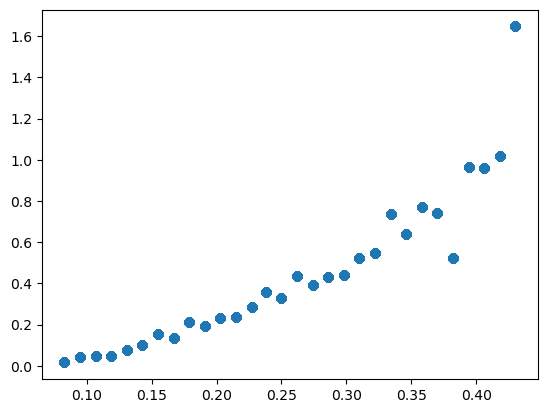

In [178]:
plt.scatter(x=[x.right for x in df_.bins.to_numpy()], y=df_.risk_free_rate)

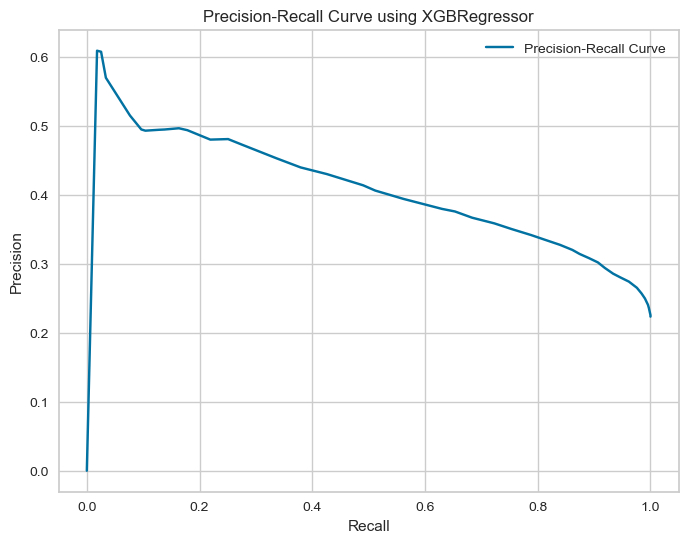

In [343]:
from sklearn.metrics import precision_score, recall_score

df_encoded.income = df_encoded.income.apply(lambda x : np.log(1+x))

# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['default']),
                                                    df_encoded['default'],
                                                    test_size=0.2,
                                                    random_state=42)

# 4. Standardize the features (Note: CatBoost doesn't necessarily require feature scaling, but we'll keep it for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Perform regression using CatBoost

best['max_depth'] = int(best['max_depth'])

best_hyperparameters = best

regressor = xgb.XGBRegressor(**best_hyperparameters) # Logging level set to 'Silent' to suppress iteration-level outputs
regressor.fit(X_train_scaled, y_train)

# Predict the continuous scores
y_scores = regressor.predict(X_test_scaled)

# Vary the threshold to get precision and recall values
thresholds = np.linspace(0, 1, 100)
precision_values = []
recall_values = []

for t in thresholds:
    y_pred = (y_scores > t).astype(int)
    precision_values.append(precision_score(y_test, y_pred, zero_division=0))
    recall_values.append(recall_score(y_test, y_pred))

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve using XGBRegressor")
plt.legend()
plt.grid(True)
plt.show()

### A try with TPOT

In [354]:
from tpot import TPOTRegressor

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [355]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['default']),
                                                    df_encoded['default'],
                                                    test_size=0.2)

# Initialize the TPOT regressor
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)

# Fit the TPOT regressor to the training data
tpot.fit(X_train, y_train)

# Print the best pipeline steps
print("\nBest Pipeline Steps:", tpot.fitted_pipeline_)

# Evaluate on the test set
print("\nTest R2 Score:", tpot.score(X_test, y_test))

# Optionally export the generated pipeline code
# tpot.export('tpot_best_model_pipeline.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.15460897624055156

Generation 2 - Current best internal CV score: -0.15460897624055156

Generation 3 - Current best internal CV score: -0.1546058349722002

Generation 4 - Current best internal CV score: -0.15460222404685953

Generation 5 - Current best internal CV score: -0.15453754045984222

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=7, min_samples_leaf=16, min_samples_split=5)

Best Pipeline Steps: Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=7, min_samples_leaf=16,
                                       min_samples_split=5, random_state=42))])

Test R2 Score: -0.15675799022305323


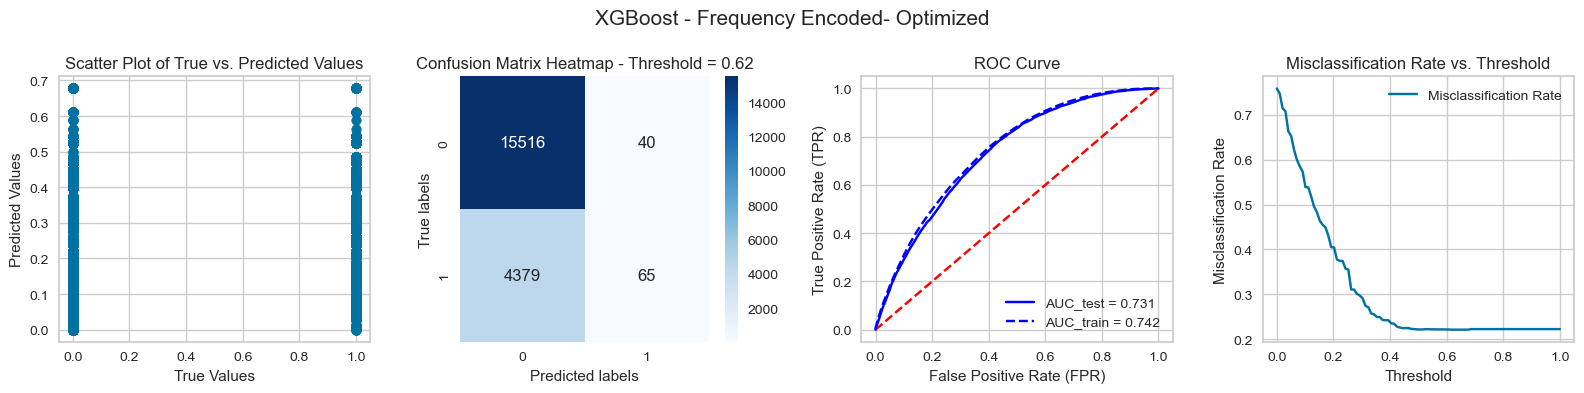

In [361]:
# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['default']),
                                                    df_encoded['default'],
                                                    test_size=0.2)

# 4. Standardize the features (Note: CatBoost doesn't necessarily require feature scaling, but we'll keep it for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Perform regression using CatBoost

regressor =  tpot.fitted_pipeline_
regressor.fit(X_train_scaled, y_train)

# Predict
y_pred = regressor.predict(X_test_scaled)

plot_func(y_test, y_pred, train=(y_train, regressor.predict(X_train_scaled)), name='XGBoost - Frequency Encoded- Optimized')


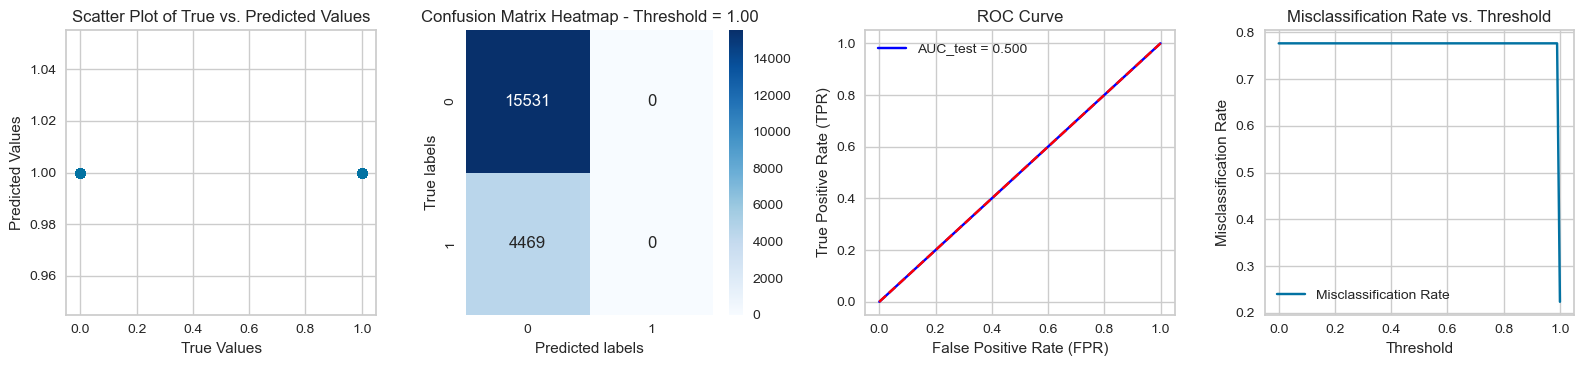

In [393]:
plot_func(y_test, y_pred**0)

### Light GBM

In [403]:
import lightgbm as lgb

In [411]:
df_past = pd.read_csv('PastLoans.csv').drop(columns=['digital1','digital2'])
df_past.income = df_past.income.astype('int32')
df_past.digital3 = df_past.digital3.astype('float32')
#df_past.employment = df_past.employment.astype('category')
#df_past.sex = df_past.sex.astype('category')
#df_past.married = df_past.married.astype('category')
#df_past.default = df_past.default.astype('category')

features_to_encode = ['employment']
df_encoded = pd.get_dummies(df_past, columns=features_to_encode)
cols_to_encode = ['sex', 'employment_employed', 'employment_retired','employment_student','employment_unemployed', 'married']

for col in cols_to_encode:
    df_encoded[col] = df_encoded[col].map(df_encoded.groupby(col)[col].count()) / df_encoded.shape[0]


#df_encoded.income = df_encoded.income.apply(lambda x : np.log(1+x))
df_encoded.income = df_encoded.income.rank()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['default']),
                                                    df_encoded['default'],
                                                    test_size=0.2,
                                                    random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(params):

    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['bagging_freq'] = int(params['bagging_freq'])
    params['min_data_in_bin'] = int(params['min_data_in_bin'])
    num_round = int(params['num_round'])
    del params['num_round']
    model = lgb.train(params, train_data, num_round, verbose_eval=False)  # Use verbose_eval=False to suppress output
    y_pred = model.predict(X_test_scaled)
    loss = 1 - roc_auc_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

# Search space for LightGBM
space = {
    'num_leaves': hp.quniform('num_leaves', 31, 255, 1),
    'max_depth': hp.quniform('max_depth', 4, 13, 1),
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'bagging_freq': hp.quniform('bagging_freq', 1, 10, 1),
    'lambda_l1': hp.uniform('lambda_l1', 0, 10),
    'lambda_l2': hp.uniform('lambda_l2', 0, 10),
    'min_data_in_bin': hp.qloguniform('min_data_in_bin', 0, 6, 1),
    'objective': 'regression',
    'metric': 'auc',
    'num_round': hp.quniform('num_round', 100, 1000, 1)
}

# Run the optimizer
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print(f"Best hyperparameters:\n{best}")

losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses, '-o', color='blue', markersize=4)
plt.title('Objective Function Value at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()


  0%|                                   | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: train() got an unexpected keyword argument 'verbose_eval'



  0%|                                   | 0/100 [00:00<?, ?trial/s, best loss=?]


TypeError: train() got an unexpected keyword argument 'verbose_eval'

### Lazy predict

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

# Load your data
df_past = pd.read_csv('PastLoans.csv').sample(1000)


df_past = pd.read_csv('PastLoans.csv').drop(columns=['digital1','digital2'])
df_past.income = df_past.income.astype('int32')
df_past.digital3 = df_past.digital3.astype('float32')
df_past.employment = df_past.employment.astype('category')
df_past.sex = df_past.sex.astype('category')
df_past.married = df_past.married.astype('category')
df_past.default = df_past.default.astype('category')
df_past.income = df_past.income.rank()

# Split the dataset
X = df_past.drop(columns=['default'])
y = df_past['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use LazyPredict's LazyRegressor
reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results
print(models)


 38%|████████████████▎                          | 11/29 [00:06<00:09,  1.80it/s]

### Stacking

In [158]:
df_past = pd.read_csv('PastLoans.csv').drop(columns=['digital1','digital2'])
df_past.income = df_past.income.astype('int32')
df_past.digital3 = df_past.digital3.astype('float32')
df_past.employment = df_past.employment.astype('category')
df_past.sex = df_past.sex.astype('category')
df_past.married = df_past.married.astype('category')
df_past.default = df_past.default.astype('category')


# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2,
                                                    random_state=42)


# Get predictions on the validation set
val_pred1 = regressor_cat.predict(X_train)
val_pred2 = regressor_xgb.predict(X_train)

# Stack predictions to serve as input features for the meta-model
stacked_val_predictions = np.column_stack((val_pred1, val_pred2))

# Train the meta-model on stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_val_predictions, y_train)

# For making predictions on new data
# First, get predictions from base models
new_data_pred1 = regressor_cat.predict(X_test)
new_data_pred2 = regressor_xgb.predict(X_test)
stacked_new_data_predictions = np.column_stack((new_data_pred1, new_data_pred2))

# Then, get the final predictions from the meta-model
final_predictions = meta_model.predict(stacked_new_data_predictions)

# Evaluate the stacked model
#stacked_preds = meta_model.predict(stacked_val_predictions)
#print("Mean Squared Error of Stacked Model:", mean_squared_error(y_val, stacked_preds))


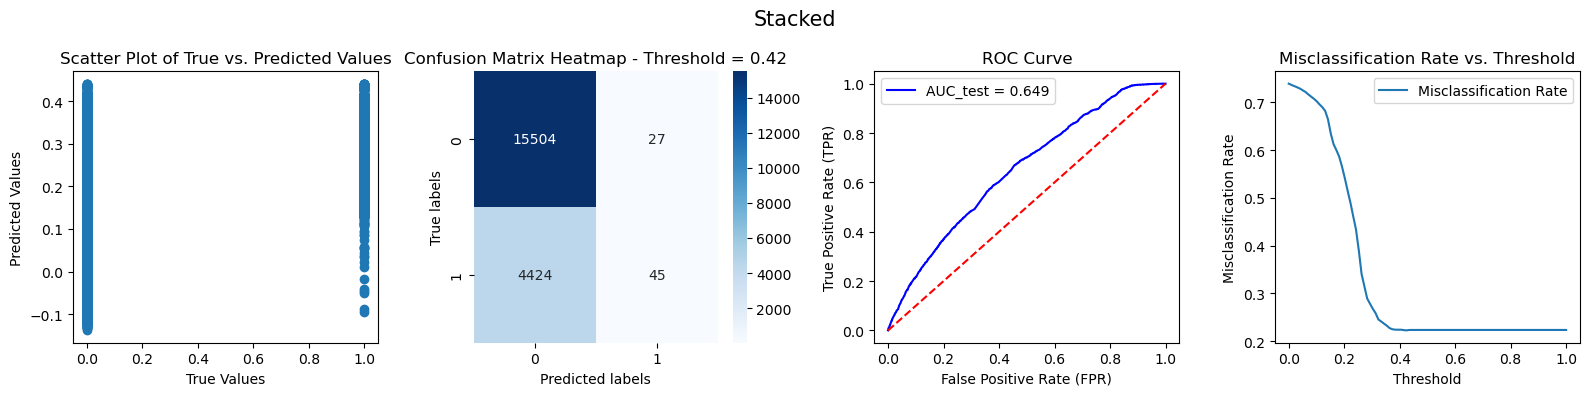

In [161]:
plot_func(y_test, final_predictions, name='Stacked')

### Logistic

In [183]:
df_past = pd.read_csv('PastLoans.csv').drop(columns=['digital1','digital2'])

In [185]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import category_encoders as ce

# Split the data into features and target
X = df_past.drop(columns=['default'])
y = df_past['default']

# Create a pipeline with target encoder and logistic regression
pipeline = make_pipeline(
    ce.TargetEncoder(cols=['employment']), 
    LogisticRegression(solver='lbfgs')
)

# Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

print(f'Mean AUC: {scores.mean():.4f}')
print(f'Standard Deviation: {scores.std():.4f}')


Mean AUC: 0.7152
Standard Deviation: 0.0033


In [207]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Assuming df_past is loaded
X = df_past.drop(columns=['target'])  # replace 'target' with your target column name
y = df_past['target']

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Create transformers
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore')
)

# Assemble column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# List of regression models to try
regressors = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge()),
    ("Lasso", Lasso()),
    ("ElasticNet", ElasticNet()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42))
]

for name, regressor in regressors:
    pipeline = make_pipeline(preprocessor, regressor)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    
    print(f"{name} - Test MSE: {mse:.4f}")


KeyError: "['target'] not found in axis"

### Cat Boost, BAG, L1

In [196]:
df_past = pd.read_csv('PastLoans.csv').drop(columns=['digital1','digital2'])
df_past.income = df_past.income.astype('int32')
df_past.digital3 = df_past.digital3.astype('float32')
df_past.employment = df_past.employment.astype('category')
df_past.sex = df_past.sex.astype('category')
df_past.married = df_past.married.astype('category')
df_past.default = df_past.default.astype('category')


X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2,
                                                    random_state=42)

In [204]:
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

best_cat = {'bootstrap_type': 2,
            'depth': 7.0,
            'grow_policy': 0,
            'l2_leaf_reg': 2.658849283525596,
            'learning_rate': 0.03669204959940085,
            'min_data_in_leaf': 7.0}

best_hyperparameters = best_cat.copy()
best_hyperparameters['bootstrap_type'] = ["Bayesian", "Bernoulli", "MVS", "No"][best_cat['bootstrap_type']]
best_hyperparameters['grow_policy'] = ["SymmetricTree", "Depthwise", "Lossguide"][best_cat['grow_policy']]
best_hyperparameters['depth'] = int(best_cat['depth'])

# Add categorical features
cat_features = X_train.select_dtypes(['category']).columns.tolist()
best_hyperparameters['cat_features'] = cat_features

# Initialize the regressor
regressor = CatBoostRegressor(**best_hyperparameters, logging_level='Silent')



# Create a Bagging classifier with CatBoost
catboost_bag = BaggingClassifier(
    base_estimator=regressor, 
    n_estimators=10, # Number of CatBoost models to train, adjust accordingly
    max_samples=0.8, # Fraction of the dataset to use for each model, adjust if needed
    max_features=1.0, # Fraction of features to use for each model
    random_state=42
)

# Create a pipeline (if necessary). 
# Here, I've included a standard scaler for demonstration purposes, but CatBoost doesn't require feature scaling.
pipeline = Pipeline([
#    ('scaler', StandardScaler()), 
    ('classifier', catboost_bag)
])

# You can then fit and predict as usual:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)


CatBoostError: features parameter contains string value 'sex' but feature names for a dataset are not specified